In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
from datetime import datetime
import json
# from underthesea import word_tokenize
from vncorenlp import VnCoreNLP
import string
# import textstat

# Load train and test data

In [3]:
train_df = pd.read_csv('data/public_train_ext.csv')
test_df = pd.read_csv('data/final_private_test_dropped_no_label.csv')

In [4]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1646 entries, 0 to 1645
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                1646 non-null   int64  
 1   user_name         1646 non-null   object 
 2   post_message      1646 non-null   object 
 3   timestamp_post    1612 non-null   float64
 4   num_like_post     1030 non-null   float64
 5   num_comment_post  969 non-null    object 
 6   num_share_post    904 non-null    object 
dtypes: float64(2), int64(1), object(4)
memory usage: 90.1+ KB


# Check word not in dict (74K word)

In [5]:
def text_to_dictionary(df, text_col):
    from collections import Counter
    texts = " ".join(df[text_col].fillna("").to_list()).replace("\n", "").lower()
    train_dict = Counter(texts.split(" "))
    train_dict_df = pd.DataFrame.from_dict(train_dict, orient='index').reset_index()
    train_dict_df = train_dict_df.rename(columns={'index': 'word', 0: 'freq'})
    train_dict_df.sort_values(by="freq", ascending=False, inplace=True)
    return train_dict_df

In [7]:
with open('data/Viet74K.txt', 'r') as f:
    content = f.read()
    dictionary = content.split("\n")
#w2v style
dictionary = [x.replace(" ", "_") for x in dictionary]

def word_not_in_dict(data, text_col, dictionary):
    return data.loc[~data[text_col].isin(dictionary)]

In [8]:
text_to_dictionary(train_df, 'post_message') # count word from text

,word,freq
143,và,10023
79,có,8961
155,của,7921
74,người,7546
245,bệnh,7255
...,...,...
22605,?*,1
8298,-19”*,1
8302,tốt.#,1
22602,ta.[<url>](<url>)[<url>](<url>),1


In [11]:
w_df = text_to_dictionary(train_df, 'post_message')
n_in_dict = word_not_in_dict(w_df, 'word', dictionary)

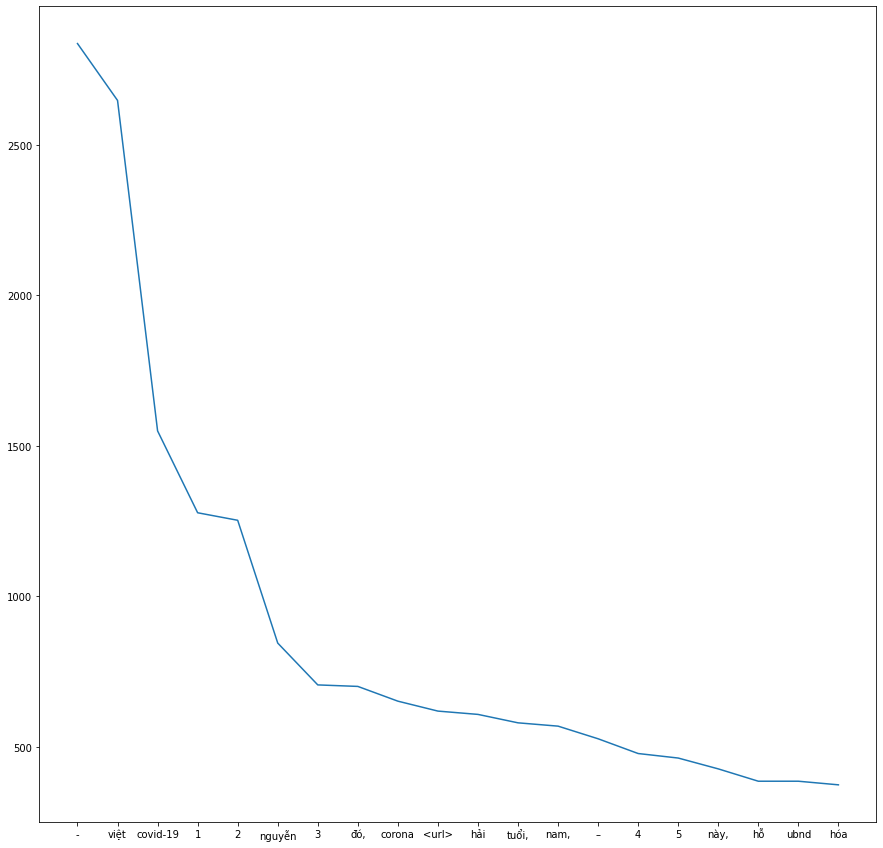

In [13]:
fig, ax = plt.subplots(figsize=(15, 15))
ax.plot(n_in_dict[0:20].word, n_in_dict[0:20].freq)

Top 20 word not in dictionary, we can see "corona", "covid-19" appear alot.

# VnCoreNLP

In [14]:
annotator = VnCoreNLP("./VnCoreNLP/VnCoreNLP-1.1.1.jar", annotators="wseg,pos")

In [15]:
annotator.tokenize("đạihọcHoaSen")

[['đạihọcHoaSen']]

In [16]:
annotator.pos_tag('VTV đồng ý chia sẻ bản quyền World Cup 2018 cho HTV để khai thác.')[0][0][1]

'Ny'

In [17]:
# make a copy if something fukup
fe_train_df = train_df.copy()

In [18]:
fe_train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5172 entries, 0 to 5171
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   id                5172 non-null   int64 
 1   user_name         5172 non-null   object
 2   post_message      5171 non-null   object
 3   timestamp_post    5008 non-null   object
 4   num_like_post     5026 non-null   object
 5   num_comment_post  5158 non-null   object
 6   num_share_post    4243 non-null   object
 7   label             5172 non-null   int64 
dtypes: int64(2), object(6)
memory usage: 323.4+ KB


<AxesSubplot:>

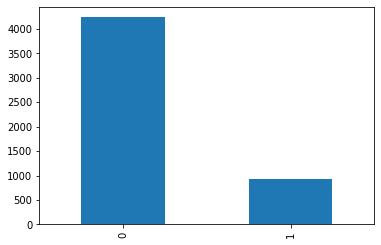

In [19]:
fe_train_df['label'].value_counts().plot(kind='bar')

Imbalance dataset

# Handle text 

In [20]:
emoji_dict = dict()
with open('./emoji_dict.json', 'r') as f:
    emoji_dict = json.load(f)

In [21]:
def replaceEmoji(s):
    if (type(s) == str):
        global emoji_dict
        s_clean = s
        for e in emoji_dict.keys():
            s_clean = s_clean.replace(e, emoji_dict[e])
        return s_clean
    return s

In [23]:
fe_train_df['clean_post_message'] = fe_train_df['post_message']
fe_train_df['clean_post_message'] = fe_train_df['clean_post_message'].apply(replaceEmoji)

In [25]:
fe_train_df.iloc[826][['post_message', 'clean_post_message']]

post_message          📣 SÁNG NAY KHÔNG CÓ CA MẮC MỚI\n\n🦠 Tổng số ca...
clean_post_message    loa phóng thanh SÁNG NAY KHÔNG CÓ CA MẮC MỚI\n...
Name: 826, dtype: object

In [26]:
def miscClean(s, tokenize=True):
    remove_misc_s = s.replace('<URL>', '')
    remove_misc_s = remove_misc_s.replace('<PHONE>', '')
    
    if tokenize:
        remove_misc_s_list = annotator.tokenize(remove_misc_s)
        remove_misc_s = ''
        for s in remove_misc_s_list:
            for w in s:
#                 if (is_digit(w)):
#                     remove_misc_s += "<number> "
#                 elif (w in string.punctuation):
#                     remove_misc_s += "<punct> "
#                 else:
                    remove_misc_s += w + " "
    
#     remove_misc_s = remove_misc_s.lower()
    remove_misc_s = remove_misc_s.strip()
    return remove_misc_s

miscClean('Phía nguyên đơn yêu cầu tòa xem xét. hủy toàn bộ quyết định của UBND <URL> về việc công nhận Hội đồng quản trị Trường đại học Hoa Sen. #đạihọcHoaSen')

'Phía nguyên_đơn yêu_cầu toà xem_xét . huỷ toàn_bộ quyết_định của UBND về việc công_nhận Hội_đồng_quản_trị Trường đại_học Hoa_Sen . # đạihọcHoaSen'

In [29]:
%%time
fe_train_df['clean_post_message'] = fe_train_df['clean_post_message'].apply(miscClean, args=(True, ))

CPU times: user 10.7 s, sys: 535 ms, total: 11.2 s
Wall time: 32.4 s


# Write output csv file

In [30]:
drop_col = ['post_message']
fe_train_df.fillna("-999", inplace=True)
fe_train_df[[f for f in fe_train_df.columns if f not in drop_col]].to_csv('clean_train_df_ext.csv', index=False)
# [f for f in fe_train_df.columns if f not in drop_col]

In [31]:
fe_test_df = test_df.copy()

In [32]:
%%time
fe_test_df['post_message'].fillna("", inplace=True)
fe_test_df['clean_post_message'] = fe_test_df['post_message']
fe_test_df['clean_post_message'] = fe_test_df['clean_post_message'].apply(replaceEmoji)
fe_test_df['clean_post_message'] = fe_test_df['clean_post_message'].apply(miscClean, args=(True, ))

CPU times: user 3.75 s, sys: 182 ms, total: 3.93 s
Wall time: 10.3 s


In [33]:
drop_col = ['post_message']
fe_test_df.fillna("-999", inplace=True)
fe_test_df[[f for f in fe_test_df.columns if f not in drop_col]].to_csv('clean_final_test_df.csv', index=False)
# [f for f in fe_train_df.columns if f not in drop_col]

In [34]:
fe_test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1646 entries, 0 to 1645
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   id                  1646 non-null   int64 
 1   user_name           1646 non-null   object
 2   post_message        1646 non-null   object
 3   timestamp_post      1646 non-null   object
 4   num_like_post       1646 non-null   object
 5   num_comment_post    1646 non-null   object
 6   num_share_post      1646 non-null   object
 7   clean_post_message  1646 non-null   object
dtypes: int64(1), object(7)
memory usage: 103.0+ KB


In [35]:
fe_train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5172 entries, 0 to 5171
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   id                  5172 non-null   int64 
 1   user_name           5172 non-null   object
 2   post_message        5172 non-null   object
 3   timestamp_post      5172 non-null   object
 4   num_like_post       5172 non-null   object
 5   num_comment_post    5172 non-null   object
 6   num_share_post      5172 non-null   object
 7   label               5172 non-null   int64 
 8   clean_post_message  5172 non-null   object
dtypes: int64(2), object(7)
memory usage: 363.8+ KB
